In [3]:

CUDA_LAUNCH_BLOCKING=1
import torch
import torch.nn as nn
import numpy as np 


import random

import tqdm
import matplotlib.pyplot as plt

In [4]:
device = torch.device("cuda:6")

H = torch.load("/home/lliu/huffman/test/original_weights_test.pt")["H"].to(device).float()
weights = torch.load("/home/lliu/huffman/test/original_weights_test.pt")["weights"].to(device).float()    



In [5]:
torch.random.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
random.seed(0)
def create_mask(data:list,percent_top):
    """
    data: list of torch.tensor of shape (n)
    percent_top: float, the percentage of the top values to keep
    """
    mask = torch.ones(data[0].shape, dtype = torch.bool, device = data[0].device)

    datas_sorted = [torch.sort(data[i], descending = True)[0] for i in range(len(data))]
    i = 0
    big_i = 0
    # print(mask.sum(), (100-percent_top)/100 * mask.numel())
    # raise ValueError("The mask is not sparse enough")
    while mask.sum() > (100-percent_top)/100 * mask.numel():
        # print(mask.sum())
        mask &= data[i%len(data)] < datas_sorted[i][big_i]
        i += 1
        i = i % len(data)
        if i == 0:
            big_i += 1
        # if i==0:
        #     raise ValueError("The mask is not sparse enough")
    # threshold = torch.quantile(data, 1-percent_top/100)
    return mask


# row_mask = create_mask([torch.norm(weights, dim = 1)], percent_dense_rowise)
# column_mask = create_mask([torch.norm(weights, dim = 0),torch.norm(H, dim = 0)], percent_dense_columnwise)

# print("row_mask.sum() = ", row_mask.sum())
# print("column_mask.sum() = ", column_mask.sum())


def mask_round(mask, d):

    while mask.sum() % d != 0:
        mask[torch.randint(0, mask.shape[0], (1,))] = False
        print(mask.sum())

    return mask

In [6]:
def weights_norm(weights, percent_dense_rowise,
                 percent_dense_columnwise):
    
    if percent_dense_columnwise == 0:
        column_mask = torch.ones(weights.shape[1], dtype = torch.bool, device = weights.device)
    else:
        column_mask = create_mask([torch.norm(weights, dim = 0),torch.norm(H, dim = 0)], percent_dense_columnwise)
        
    if percent_dense_rowise == 0:
        
        row_mask = torch.ones(weights.shape[0], dtype = torch.bool, device = weights.device)    
    else:
        row_mask = create_mask([torch.norm(weights, dim = 1)], percent_dense_rowise)

    

    weights_adjusted = weights[row_mask,:][:, column_mask]
    # print()
    weights_norms_rowwise = torch.norm(weights_adjusted, dim = 0)
    print(weights_norms_rowwise.shape)
    weights_norms_rowwise[torch.isclose(weights_norms_rowwise, torch.zeros_like(weights_norms_rowwise))] = 1
    weights_normalized = weights_adjusted / weights_norms_rowwise.unsqueeze(0)
    weights_norms_columnwise = torch.norm(weights_normalized, dim = 1)
    weights_norms_columnwise[torch.isclose(weights_norms_columnwise, torch.zeros_like(weights_norms_columnwise))] = 1
    weights_normalized = weights_normalized / weights_norms_columnwise.unsqueeze(1)
    return weights_normalized

In [12]:
device = torch.device("cuda:6")

# H = torch.load("/home/lliu/huffman/test/original_weights_test.pt")["H"].to(device).float()
weights_mlp = torch.load("/home/lliu/huffman/test/original_weights_test.pt")["weights"].to(device).float()    
weights_attention = torch.load("/home/lliu/huffman/test/original_weights.pt")["weights"].to(device).float()    

weights_mlp_normalized = weights_norm(weights_mlp, 0.5,1)
weights_attention_normalized = weights_norm(weights_attention, 0.5,1)

torch.Size([4055])
torch.Size([4055])


In [18]:
_,S_mlp,_ = torch.svd(weights_mlp_normalized, compute_uv = False)
_,S_mlp_non_normalized,_ = torch.svd(weights_mlp, compute_uv = False)


d1,d2 = weights_mlp_normalized.shape
d = min(d1,d2)
X_padded = torch.zeros(d*np.ceil(d1/d).astype(int),d*np.ceil(d2/d).astype(int),device = weights_mlp_normalized.device)
X_padded[:d1,:d2] = weights_mlp_normalized

_, S_mlp_try2, _ = torch.svd(X_padded.reshape(-1,d,d), compute_uv = False)

In [19]:
_,S_attention,_ = torch.svd(weights_attention_normalized, compute_uv = False)
_,S_attention_non_normalized,_ = torch.svd(weights_attention, compute_uv = False)

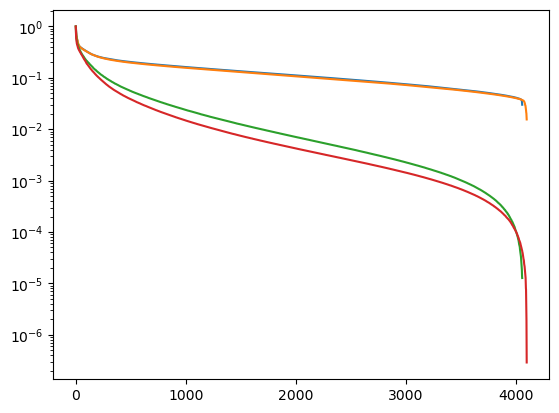

In [20]:
plt.plot(S_mlp.cpu().numpy()/S_mlp.max().item())
plt.plot(S_mlp_non_normalized.cpu().numpy()/S_mlp_non_normalized.max().item())
plt.plot(S_mlp_try2[0].cpu().numpy()/S_mlp_try2[0].max().item())
plt.plot(S_mlp_try2[1].cpu().numpy()/S_mlp_try2[1].max().item())
plt.plot(S_mlp_try2[2].cpu().numpy()/S_mlp_try2[2].max().item())
plt.plot(S_attention.cpu().numpy()/S_attention.max().item())
plt.plot(S_attention_non_normalized.cpu().numpy()/S_attention_non_normalized.max().item())
plt.plot()
plt.yscale("log")

In [61]:
S

tensor([10.8926, 10.3614,  9.3465,  ...,  0.4122,  0.4109,  0.3837],
       device='cuda:6')

In [87]:
class low_rank_optimizer(nn.Module):

    def __init__(self,X,low_rank_frac):
        super(low_rank_optimizer, self).__init__()
        
        d1,d2 = X.shape
        self.dims = (d1,d2)
        d = min(d1,d2)
        X_padded = torch.zeros(d*np.ceil(d1/d).astype(int),d*np.ceil(d2/d).astype(int),device = X.device)
        X_padded[:d1,:d2] = X
        print(X_padded.shape)
        self.padded_dims = X_padded.shape
        U, S, V = torch.svd(X_padded.reshape(-1,d,d))
        print(U.shape, S.shape, V.shape)
        # raise ValueError("stop")
        low_rank = int(low_rank_frac * d)
        print(low_rank)
        print(U[...,:low_rank].shape, S[...,:low_rank].shape, V[...,:low_rank].shape)
        self.A = nn.Parameter(torch.einsum("ijk,ik->ijk", U[...,:low_rank], torch.sqrt(S[...,:low_rank])))
        self.B = nn.Parameter(torch.einsum("ijk,ik->ijk", V[...,:low_rank], torch.sqrt(S[...,:low_rank])).transpose(1,2))
        print(self.A.shape, self.B.shape)

    def forward(self):
        raw = (self.A @ self.B).reshape(self.padded_dims)
        return raw[:self.dims[0],:self.dims[1]]

In [90]:
#do a svd decomposition


k = 256



lora_module = low_rank_optimizer(weights_normalized, 1/16).to(device)
lora_overhead = 16*(lora_module.A.numel() + lora_module.B.numel())/(weights.numel())
sparse_overhead = 16*(torch.sum(~mask).item())/(weights.numel())
total_bits = 16*(lora_module.A.numel() + lora_module.B.numel() + torch.sum(~mask).item())
print("total_bits = ", total_bits, "bits per weight = ", total_bits/weights.numel(),
        "lora_overhead = ", lora_overhead, "sparse_overhead = ", sparse_overhead)
optimizer = torch.optim.Adam(lora_module.parameters(), lr = 1e-3)
n_iters = 1000
lr = 5e-2
grad_clip = 1e-1
lr_multiple = 0.9
prev_H_error = 1e10
losses = []
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma = lr_multiple)

for i in tqdm.tqdm(range(n_iters)):

    weights_reconstructed = torch.zeros_like(weights)
    weights_reconstructed[mask] = ((lora_module()) * weights_norms_rowwise.unsqueeze(0) * weights_norms_columnwise.unsqueeze(1)
                                   ).flatten()
    weights_reconstructed[~mask] = weights[~mask]

    diff = weights - weights_reconstructed

    average_error = torch.sum(torch.abs(diff)**1)/torch.sum(torch.abs(weights)**1)

    H_error = torch.einsum('ik,kl,il->', diff, H/H.shape[0], diff)
    if H_error < 1e-5:
        break
    if i % 50 == 0:
        print("average_error = ", average_error.item(), "H_error = ", H_error.item())
    H_error.backward()
    losses.append(H_error.item())

    if H_error > prev_H_error:
        lr_scheduler.step()
    prev_H_error = H_error.item()
    # print(lora_module.A.grad)
    # raise ValueError("stop")
    nn.utils.clip_grad_norm_(lora_module.parameters(), grad_clip)
    optimizer.step()
    optimizer.zero_grad()
    # with torch.no_grad():
    #     if i % 1 == 0:
    #         #update A
    #         A.grad = A.grad.clamp(-grad_clip, grad_clip)
    #         A -= lr * A.grad
    #         A.grad.zero_()

    #     # else:
    #         #update B
    #         B.grad = B.grad.clamp(-grad_clip, grad_clip)
    #         B -= lr * B.grad
    #         B.grad.zero_()

torch.Size([11520, 3840])


torch.Size([3, 3840, 3840]) torch.Size([3, 3840]) torch.Size([3, 3840, 3840])
240
torch.Size([3, 3840, 240]) torch.Size([3, 240]) torch.Size([3, 3840, 240])
torch.Size([3, 3840, 240]) torch.Size([3, 240, 3840])
total_bits =  175833088 bits per weight =  3.8997093023255816 lora_overhead =  1.9622093023255813 sparse_overhead =  1.9375


  0%|          | 1/1000 [00:00<03:06,  5.35it/s]

average_error =  0.6779252290725708 H_error =  1249.8543701171875


  5%|▌         | 51/1000 [00:09<02:55,  5.41it/s]

average_error =  0.7076277732849121 H_error =  759.5531616210938


 10%|█         | 101/1000 [00:18<02:46,  5.41it/s]

average_error =  0.7070355415344238 H_error =  743.984130859375


 15%|█▌        | 151/1000 [00:27<02:36,  5.42it/s]

average_error =  0.7065509557723999 H_error =  741.390380859375


 20%|██        | 201/1000 [00:36<02:28,  5.39it/s]

average_error =  0.7062996029853821 H_error =  740.5905151367188


 25%|██▌       | 251/1000 [00:46<02:18,  5.40it/s]

average_error =  0.7061969041824341 H_error =  740.3030395507812


 30%|███       | 301/1000 [00:55<02:06,  5.51it/s]

average_error =  0.7061411738395691 H_error =  740.1368408203125


 35%|███▌      | 351/1000 [01:04<02:00,  5.41it/s]

average_error =  0.7061160206794739 H_error =  740.043701171875


 40%|████      | 401/1000 [01:13<01:48,  5.53it/s]

average_error =  0.7061079144477844 H_error =  740.0045166015625


 45%|████▌     | 451/1000 [01:22<01:41,  5.40it/s]

average_error =  0.7061022520065308 H_error =  739.9719848632812


 50%|█████     | 501/1000 [01:31<01:32,  5.42it/s]

average_error =  0.7060994505882263 H_error =  739.9443359375


 55%|█████▌    | 551/1000 [01:41<01:23,  5.35it/s]

average_error =  0.706098198890686 H_error =  739.9249877929688


 60%|██████    | 601/1000 [01:50<01:13,  5.40it/s]

average_error =  0.7060978412628174 H_error =  739.910400390625


 65%|██████▌   | 651/1000 [01:59<01:04,  5.39it/s]

average_error =  0.7060977816581726 H_error =  739.8997192382812


 70%|███████   | 701/1000 [02:08<00:54,  5.47it/s]

average_error =  0.7060975432395935 H_error =  739.8919677734375


 75%|███████▌  | 751/1000 [02:17<00:44,  5.59it/s]

average_error =  0.706097424030304 H_error =  739.8882446289062


 80%|████████  | 801/1000 [02:26<00:36,  5.43it/s]

average_error =  0.7060972452163696 H_error =  739.8846435546875


 85%|████████▌ | 851/1000 [02:36<00:26,  5.57it/s]

average_error =  0.7060970664024353 H_error =  739.880859375


 90%|█████████ | 901/1000 [02:45<00:17,  5.52it/s]

average_error =  0.7060969471931458 H_error =  739.8779296875


 95%|█████████▌| 951/1000 [02:54<00:08,  5.50it/s]

average_error =  0.7060968279838562 H_error =  739.8760986328125


100%|██████████| 1000/1000 [03:03<00:00,  5.45it/s]


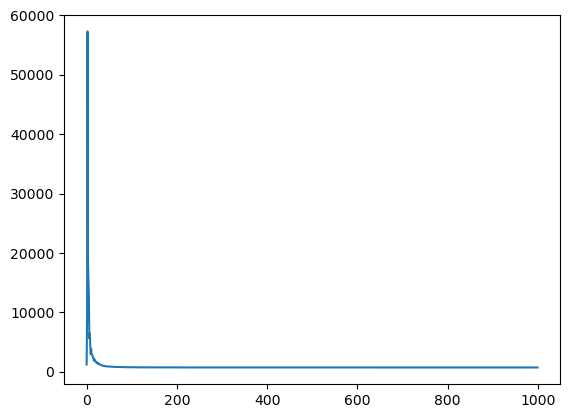

In [89]:
plt.plot(losses)

In [30]:
A = lora_module.A
B = lora_module.B

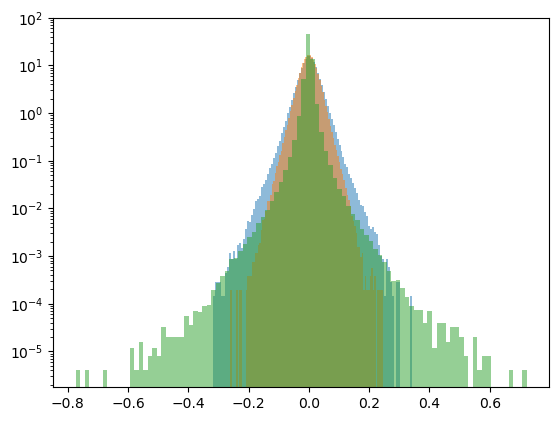

In [31]:
plt.hist(A.flatten().detach().cpu().numpy(), bins = 100, density=True, alpha = 0.5)
plt.hist(B.flatten().detach().cpu().numpy(), bins = 100, density=True, alpha = 0.5)
plt.hist(weights.flatten().detach().cpu().numpy(), bins = 100, density=True, alpha = 0.5)
plt.yscale("log")

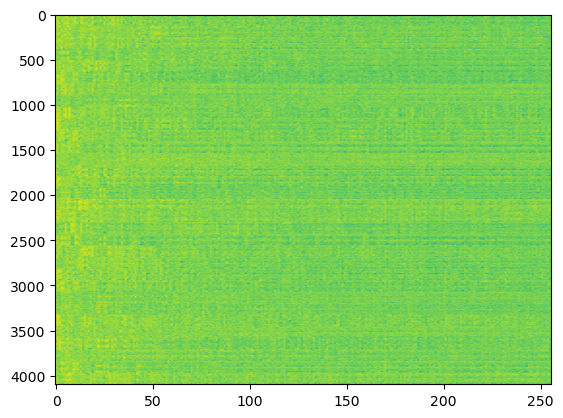

In [32]:
plt.imshow(np.log(np.abs(A.detach().cpu().numpy())), aspect = "auto")

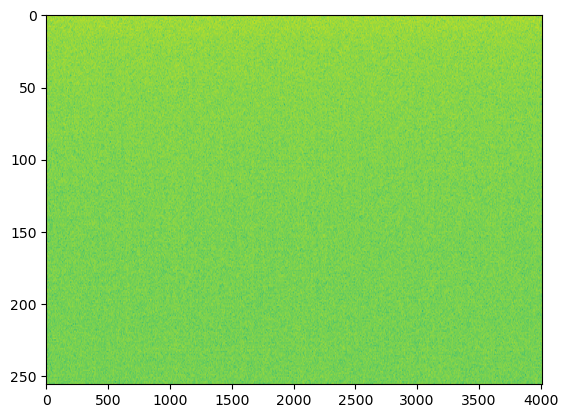

In [33]:
plt.imshow(np.log(np.abs(B.detach().cpu().numpy())), aspect = "auto")

In [34]:
A = A.detach().requires_grad_(False)
B = B.detach().requires_grad_(False)

In [35]:
class lora_quantizer_module(nn.Module):
    def __init__(self, A, B, n_bits):
        super(lora_quantizer_module, self).__init__()

        self.A_codebook = nn.Parameter(torch.linspace(A.min(), A.max(), 2**n_bits).to(A.device))
        self.B_codebook = nn.Parameter(torch.linspace(B.min(), B.max(), 2**n_bits).to(B.device))

    def forward(self, A_assignments, B_assignments):
        return self.A_codebook[A_assignments] @ self.B_codebook[B_assignments]
    
    def recompute_assignments(self, A, B):
        
        with torch.no_grad():
            A_assignments = torch.argmin(torch.abs(self.A_codebook.reshape([1]*len(A.shape) + list(self.A_codebook.shape)) - A.unsqueeze(-1)), dim = -1)
            B_assignments = torch.argmin(torch.abs(self.B_codebook.reshape([1]*len(B.shape) + list(self.B_codebook.shape)) - B.unsqueeze(-1)), dim = -1)
            return A_assignments, B_assignments

In [36]:
n_bits =  6


quantized_low_rank_bits = (n_bits*A.numel() + n_bits*B.numel())
total_bits = 16*(torch.sum(~mask).item()) + 16*(2*2**n_bits) + quantized_low_rank_bits

print("quantized_low_rank_bits = ", quantized_low_rank_bits/weights.numel(), "bits per weight = ", (total_bits)
                                                                                                    /weights.numel())

lora_quantizer = lora_quantizer_module(A, B, n_bits).to(device)
lora_quantizer_optimizer = torch.optim.Adam(lora_quantizer.parameters(), lr = 1e-2)

A_assignments, B_assignments = lora_quantizer.recompute_assignments(A, B)

n_iters = 1000
lr = 1e-1
grad_clip = 1e-1
lr_multiple = 0.9
prev_H_error = 1e10
patience = 100
patience_used = 0
eps = 1e-3

lr_scheduler = torch.optim.lr_scheduler.StepLR(lora_quantizer_optimizer, step_size = 1, gamma = lr_multiple)

for i in tqdm.tqdm(range(n_iters)):
    
    # A_quantized, B_quantized = lora_quantizer(A_assignments, B_assignments)
    # print("A_quantized = ", A_quantized.shape, "A= ", A.shape)
    # print("B_quantized = ", B_quantized.shape, "B= ", B.shape)
    # raise ValueError("stop")

    weights_reconstructed = torch.zeros_like(weights)
    weights_reconstructed[mask] = ((lora_quantizer(A_assignments, B_assignments)) * weights_norms_rowwise.unsqueeze(0) * weights_norms_columnwise.unsqueeze(1)
                                   ).flatten()
    weights_reconstructed[~mask] = weights[~mask]

    diff = weights - weights_reconstructed

    average_error = torch.sum(torch.abs(diff)**1)/torch.sum(torch.abs(weights)**1)

    H_error = torch.einsum('ik,kl,il->', diff, H/H.shape[0], diff)
    # print("average_error = ", average_error.item(), "H_error = ", H_error.item())
    # raise ValueError("stop")
    if H_error < 1e-5:
        break
    if i % 50 == 0:
        print("average_error = ", average_error.item(), "H_error = ", H_error.item())
    H_error.backward()
    losses.append(H_error.item())


    nn.utils.clip_grad_norm_(lora_quantizer.parameters(), grad_clip)
    lora_quantizer_optimizer.step()
    lora_quantizer_optimizer.zero_grad()

    if prev_H_error - H_error < eps:
        lr_scheduler.step()
        # print("lr = ", lr)
        patience_used += 1
        if patience_used > patience:
            break
    else:
        patience_used = 0
        prev_H_error = H_error.item()

    A_assignments, B_assignments = lora_quantizer.recompute_assignments(A, B)

    

print("average_error = ", average_error.item(), "H_error = ", H_error.item())

quantized_low_rank_bits =  0.74249267578125 bits per weight =  1.06292724609375


  0%|          | 1/1000 [00:00<02:54,  5.74it/s]

average_error =  0.27502354979515076 H_error =  4.347078800201416


  5%|▌         | 52/1000 [00:05<01:24, 11.17it/s]

average_error =  0.26172879338264465 H_error =  2.3985934257507324


 10%|█         | 102/1000 [00:09<01:15, 11.92it/s]

average_error =  0.26178354024887085 H_error =  2.387420177459717


 15%|█▌        | 150/1000 [00:13<01:15, 11.20it/s]

average_error =  0.26177069544792175 H_error =  2.3802309036254883


 15%|█▌        | 153/1000 [00:14<01:18, 10.74it/s]

average_error =  0.26177048683166504 H_error =  2.380289316177368


In [102]:
H_error

tensor(7.9834, device='cuda:6', grad_fn=<ViewBackward0>)

In [26]:
diff = weights - weights_reconstructed

average_error = torch.sum(torch.abs(diff)**1)/torch.sum(torch.abs(weights)**1)

H_error = torch.einsum('ik,kl,il->', diff, H/H.shape[0], diff)

print("average_error = ", average_error, "H_error = ", H_error)

average_error =  tensor(0.5148, device='cuda:6') H_error =  tensor(3955.0728, device='cuda:6')
